In [1]:
import pandas as pd
import datetime as dt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats

In [2]:
def shift_y(series):
    if series['Month'] == 1:
        return series['Year']-1
    else:
        return series['Year']
def shift_m(series):
    if series['Month'] == 1:
        return 12
    else:
        return series['Month']-1


In [3]:
#Download utilities and shift year/month by one
df0 = pd.read_csv('~/Downloads/repairs_utilities_all_sqft.csv')
df1 = pd.read_csv('~/Downloads/utilities_sqft.csv')
df0['YearShift'] = df0[['Year', 'Month']].apply(shift_y, axis=1)
df0['MonthShift'] = df0[['Year', 'Month']].apply(shift_m, axis=1)

df1['YearShift'] = df1[['Year', 'Month']].apply(shift_y, axis=1)
df1['MonthShift'] = df1[['Year', 'Month']].apply(shift_m, axis=1)

#Choose specifically RGAS
df = df1[df1['ServiceType']=='RGAS']
df.shape

(722576, 11)

In [4]:
#Include only addresses which have active projects
project_addresses = df0['address'].unique()
df = df[~df['address'].isin(project_addresses)]
df.shape

(719917, 11)

In [5]:
df.groupby(by=['Year', 'Month']).count()
df[(df['Month']==10) & (df['Year']==2018)].groupby(by='address').count()

,ServiceType,Consumption,DaysOfService,Year,Month,ChargeDate,PrimaryID,ConsumptionPerSQFT,YearShift,MonthShift
address,,,,,,,,,,
100 FORD ST,1,1,1,1,1,1,1,1,1,1
100 HONEYSUCKLE DR,3,3,3,3,3,3,3,3,3,3
100 S INGLESIDE DR,3,3,3,3,3,3,3,3,3,3
1000 10TH AVE,3,3,3,3,3,3,3,3,3,3
1000 11TH AVE,3,3,3,3,3,3,3,3,3,3
1000 6TH AVE,3,3,3,3,3,3,3,3,3,3
1000 7TH AVE,3,3,3,3,3,3,3,3,3,3
1000 AUGUSTA DR,3,3,3,3,3,3,3,3,3,3
1000 DON CUTLER SR DR,3,3,3,3,3,3,3,3,3,3


In [6]:
#group by month, year, address, type
sr = df.loc[:, ['YearShift', 'MonthShift', 'ServiceType', 'address', 'ChargeAmount', 'Consumption']].copy().groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address'])
sr = sr.sum().reset_index()
#Get consumption and weather normalized by days per month
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
sr['Consumption_norm'] = sr['Consumption']
for y in range(2001, 2020):
    for m in range(1,13):
        record_u = sr.loc[(sr['YearShift']==y)&(sr['MonthShift']==m), :]
        #Temp fix
        if y == 2018 and m == 9:
            sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, 'Consumption']/days_per_month[m-1]/3
        if y%4 == 0:
            sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, 'Consumption']/days_per_month_ly[m-1]
        else:
            sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, 'Consumption']/days_per_month[m-1]
         

/home/mirabel/Documents/cds/cds_env/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
#Include only addresses which have consistent month data for the type
ct = sr.groupby(by=['address']).count()
addresses = ct[ct['Consumption']>=80]
sr_sub = sr[sr['address'].isin(addresses.index)].copy()
#Drop addresses which have years that had no consumption
gp = sr_sub.groupby(by=['address', 'YearShift']).sum()
drop_addrs = []
for a in gp.index.levels[0]:
    drop=False
    for y in range(2011, 2019):
        try:
            if gp.loc[a,y]['Consumption_norm'] == 0:
                drop=True
        except TypeError:
            drop=True
    if drop:
        drop_addrs.append(a)
drop_idx = sr_sub[sr_sub['address'].isin(drop_addrs)].index
sr_sub.drop(drop_idx, inplace=True)
#Get the minimum and maximum values
min_c = sr_sub[['Consumption_norm', 'address']].groupby(by='address').min()
max_c = sr_sub[['Consumption_norm', 'address']].groupby(by='address').max()

In [8]:
def normalize(series):
    a = series['address']
    mi = 0
    ma = max_c.loc[a]['Consumption_norm']
    return (series['Consumption_norm']-mi)/(ma-mi)
sr_sub['Consumption_01'] = sr_sub.apply(normalize, axis=1)
#min_c.loc['1226 E ROOSEVELT AVE']

In [9]:
#Examine the distribution of 01 consumption per month
gp = sr_sub.groupby(by=['YearShift', 'MonthShift'])
average = gp.mean().reset_index(level=[0,1])

/home/mirabel/Documents/cds/cds_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


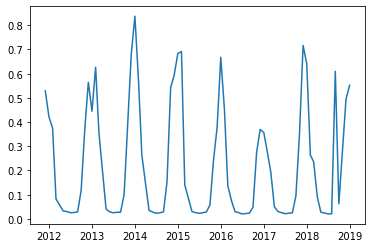

In [10]:
#plot average normalized consumption over time
def toDateMY(series):
    return dt.datetime.strptime(""+str(int(series['YearShift']))+"-"+str(int(series['MonthShift']))+"-01", '%Y-%m-%d')
average['Date']=average.apply(toDateMY, axis=1)
plt.plot(average['Date'], average['Consumption_01'], '-')
plt.show()

In [11]:
average.to_csv("~/Downloads/avg_gas.csv", index=False)

In [12]:
#Weird outlier month in elec
sr[(sr['MonthShift']==9) & (sr['YearShift']==2018)]

,YearShift,MonthShift,ServiceType,address,ChargeAmount,Consumption,Consumption_norm
659947,2018,9,RGAS,100 FORD ST,0.0,11,0.366667
659948,2018,9,RGAS,100 HONEYSUCKLE DR,0.0,6,0.200000
659949,2018,9,RGAS,100 S INGLESIDE DR,0.0,78,2.600000
659950,2018,9,RGAS,1000 10TH AVE,0.0,86,2.866667
659951,2018,9,RGAS,1000 11TH AVE,0.0,149,4.966667
659952,2018,9,RGAS,1000 6TH AVE,0.0,70,2.333333
659953,2018,9,RGAS,1000 7TH AVE,0.0,2,0.066667
659954,2018,9,RGAS,1000 AUGUSTA DR,0.0,66,2.200000
659955,2018,9,RGAS,1000 DON CUTLER SR DR,0.0,0,0.000000
659956,2018,9,RGAS,1000 E SOCIETY AVE,0.0,0,0.000000


### Statistical Tests

In [ ]:
#Consumption per month is not normal
ONE_MONTH = sr_sub[(sr_sub['MonthShift']==2) & (sr_sub['YearShift'] == 2015)]
#stats.probplot(ONE_MONTH['Consumption_norm'], dist="norm", plot=pylab)
stats.shapiro(ONE_MONTH['Consumption_01'])